# Imports

In [4]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import requests
from io import StringIO
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, silhouette_score
from collections import namedtuple
from scipy import stats
from os import path
import time
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from joblib import Parallel, delayed
from itertools import product
from sklearn.decomposition import PCA


# Parameters

In [5]:
timelimit = 300
Connectionist_bench_sonar = pd.read_csv("./data/Connectionist-bench-sonar.csv")
cylinder_bands = pd.read_csv("./data/cylinder-bands_enc.csv")
Qsar_biodegradation = pd.read_csv("./data/QSAR-biodegradation.csv")
Statlog_project_German_credit = pd.read_csv("./data/Statlog-project-German-credit_enc.csv")

datasets = {
    "Connectionist_bench_sonar": Connectionist_bench_sonar,
    "cylinder_bands": cylinder_bands,
    "Qsar_biodegradation": Qsar_biodegradation,
    "Statlog_project_German_credit": Statlog_project_German_credit,
}

alpha = [0, 0.1, 0.01]
depth = [2, 3, 4, 5]
seeds = [37, 42, 53]

# training, validation, and testing set spliting ratios
train_ratio = 0.5
val_ratio = 0.25
test_ratio = 0.25

nmin = 1

# Functions

## find_optimal_features

### New algorithm

In [115]:
def find_optimal_features(X, y, p=0.1, random_state=42):
    best_accuracy = 0
    best_features = None
    
    n_features = X.shape[1]
    remaining_features = list(range(n_features))
    
    n_remove = round(p * n_features)  # Calculate the number of features to remove based on the original dataset size
    
    while len(remaining_features) > 0:
        # Step 1: Split the data
        X_train, X_test, y_train, y_test = train_test_split(X[:, remaining_features], y, test_size=0.2, random_state=random_state)
        
        # Step 2: Train Random Forest and calculate feature importances
        rf = RandomForestClassifier(n_estimators=100, random_state=random_state)
        rf.fit(X_train, y_train)
        feature_importances = rf.feature_importances_
        
        # Step 3: Rank features and remove p% least important
        sorted_indices = np.argsort(feature_importances)
        remaining_features = [remaining_features[i] for i in sorted_indices[:-n_remove]]  # Remove n_remove features
        
        # Step 4: Train Random Forest on reduced feature set and evaluate on test data
        if len(remaining_features) > 0:
            X_train_reduced = X_train[:, :-n_remove]
            X_test_reduced = X_test[:, :-n_remove]

            rf = RandomForestClassifier(n_estimators=100, random_state=random_state)
            rf.fit(X_train_reduced, y_train)
            y_pred = rf.predict(X_test_reduced)
            accuracy = accuracy_score(y_test, y_pred)
            
            # Step 5: Check if the current feature set has the best accuracy
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_features = remaining_features
        else:
            break
    
    return best_features


### Old algorithm

In [6]:
# Iteratively selects a subset of features, trains a RandomForestClassifier, 
# and evaluates its performance until the accuracy reaches at least 98% of the full-feature model's accuracy.
def find_optimal_features(X, y, threshold=0.98, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=random_state)

    clf = RandomForestClassifier(n_estimators=100, random_state=random_state)
    clf.fit(X_train, y_train)
    full_accuracy = clf.score(X_test, y_test)
    importance_scores = clf.feature_importances_
    sorted_indices = np.argsort(importance_scores)[::-1]

    for i in range(1, len(sorted_indices) + 1):
        selected_features = sorted_indices[:i]
        new_X = pd.DataFrame(X).iloc[:, selected_features]

        X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.5, random_state=random_state)

        clf = RandomForestClassifier(n_estimators=100, random_state=random_state)
        clf.fit(X_train, y_train)
        reduced_accuracy = clf.score(X_test, y_test)

        if reduced_accuracy / full_accuracy >= threshold:
            return selected_features, reduced_accuracy

    return None, None

## optimalDecisionTreeClassifier

In [146]:
class optimalDecisionTreeClassifier:
    """
    optimal classification tree
    """
    def __init__(self, max_depth=3, min_samples_split=2, alpha=0, warmstart=True, timelimit=600, output=True):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.alpha = alpha
        self.warmstart = warmstart
        self.timelimit = timelimit
        self.output = output
        self.trained = False
        self.optgap = None
        self._obj = None
        self._bd = None

        self.last_update_time = 0
        self.update_interval = 1  # Update every second
        self.upper_bounds = []
        self.lower_bounds = []
        self.times = []


        # node index
        self.n_index = [i+1 for i in range(2 ** (self.max_depth + 1) - 1)]
        self.b_index = self.n_index[:-2**self.max_depth] # branch nodes
        self.l_index = self.n_index[-2**self.max_depth:] # leaf nodes


    def _callback(self, model, where):
        if where == GRB.Callback.MIP:
            time_elapsed = model.cbGet(GRB.Callback.RUNTIME)
            best_obj = model.cbGet(GRB.Callback.MIP_OBJBST)
            best_bound = model.cbGet(GRB.Callback.MIP_OBJBND)
            
            if self._obj != best_obj or self._bd != best_bound:
                self._obj = best_obj
                self._bd = best_bound
            # if time_elapsed - self.last_update_time >= self.update_interval:
                self.times.append(time_elapsed)
                self.upper_bounds.append(best_obj)
                self.lower_bounds.append(best_bound)
                # self.last_update_time = time_elapsed

    def fit(self, x, y):
        """
        fit training data
        """
        # data size
        self.n, self.p = x.shape
        if self.output:
            print('Training data include {} instances, {} features.'.format(self.n,self.p))

        # labels
        self.labels = np.unique(y)

        # scale data
        self.scales = np.max(x, axis=0)
        self.scales[self.scales == 0] = 1

        # solve MIP
        m, a, b, c, d, l = self._buildMIP(x/self.scales, y)
        if self.warmstart:
            self._setStart(x, y, a, c, d, l)

        # set the callback
        m._callback = self._callback

        # optimize with the callback
        m.optimize(lambda model, where: self._callback(model, where))

        # m.optimize()
        self.optgap = m.MIPGap

        # get parameters
        self._a = {ind:a[ind].x for ind in a}
        self._b = {ind:b[ind].x for ind in b}
        self._c = {ind:c[ind].x for ind in c}
        self._d = {ind:d[ind].x for ind in d}

        self.trained = True

        # # Check if each leaf node has a label
        # leaf_nodes = set(self.l_index)
        # assigned_leaf_nodes = set()
        # for ind in self._c:
        #     if self._c[ind] >= 1e-2:
        #         assigned_leaf_nodes.add(ind[1])

        # unassigned_leaf_nodes = leaf_nodes - assigned_leaf_nodes

        # if len(unassigned_leaf_nodes) > 0:
        #     print(f"Warning: {len(unassigned_leaf_nodes)} leaf nodes do not have assigned labels.")
        #     print("Unassigned leaf nodes:", unassigned_leaf_nodes)
        # else:
        #     print("All leaf nodes have assigned labels.")

        # return self

    def predict(self, x):
        """
        model prediction
        """
        if not self.trained:
            raise AssertionError('This optimalDecisionTreeClassifier instance is not fitted yet.')

        # leaf label
        labelmap = {}
        for t in self.l_index:
            for k in self.labels:
                if self._c[k,t] >= 1e-2:
                    labelmap[t] = k

        y_pred = []
        for xi in x/self.scales:
            t = 1
            while t not in self.l_index:
                right = (sum([self._a[j,t] * xi[j] for j in range(self.p)]) + 1e-9 >= self._b[t])
                if right:
                    t = 2 * t + 1
                else:
                    t = 2 * t
            # label
            # print("Debug: t =", t, "labelmap =", labelmap)
            y_pred.append(labelmap[t])

        return np.array(y_pred)

    def _buildMIP(self, x, y):
        """
        build MIP formulation for Optimal Decision Tree
        """
        # create a model
        m = gp.Model('m')

        # output
        m.Params.outputFlag = self.output
        m.Params.LogToConsole = self.output
        # time limit
        m.Params.timelimit = self.timelimit

        # #Gap tolerance
        # m.Params.MIPGap = 0.01
        
        # model sense
        m.modelSense = GRB.MINIMIZE

        # variables
        a = m.addVars(self.p, self.b_index, vtype=GRB.BINARY, name='a') # splitting feature
        b = m.addVars(self.b_index, vtype=GRB.CONTINUOUS, name='b') # splitting threshold
        c = m.addVars(self.labels, self.l_index, vtype=GRB.BINARY, name='c') # node prediction
        d = m.addVars(self.b_index, vtype=GRB.BINARY, name='d') # splitting option
        z = m.addVars(self.n, self.l_index, vtype=GRB.BINARY, name='z') # leaf node assignment
        l = m.addVars(self.l_index, vtype=GRB.BINARY, name='l') # leaf node activation
        L = m.addVars(self.l_index, vtype=GRB.CONTINUOUS, name='L') # leaf node misclassified
        M = m.addVars(self.labels, self.l_index, vtype=GRB.CONTINUOUS, name='M') # leaf node samples with label
        N = m.addVars(self.l_index, vtype=GRB.CONTINUOUS, name='N') # leaf node samples

        # calculate baseline accuracy
        baseline = self._calBaseline(y)

        # calculate minimum distance
        min_dis = self._calMinDist(x)

        # objective function
        obj = L.sum() / baseline + self.alpha * d.sum()
        m.setObjective(obj)

        # constraints
        # (20)
        m.addConstrs(L[t] >= N[t] - M[k,t] - self.n * (1 - c[k,t]) for t in self.l_index for k in self.labels)
        # (21)
        m.addConstrs(L[t] <= N[t] - M[k,t] + self.n * c[k,t] for t in self.l_index for k in self.labels)
        # (17)
        m.addConstrs(gp.quicksum((y[i] == k) * z[i,t] for i in range(self.n)) == M[k,t]
                                 for t in self.l_index for k in self.labels)
        # (16)
        m.addConstrs(z.sum('*', t) == N[t] for t in self.l_index)
        # (18)
        m.addConstrs(c.sum('*', t) == l[t] for t in self.l_index)
        # (13) and (14)
        for t in self.l_index:
            left = (t % 2 == 0)
            ta = t // 2
            while ta != 0:
                if left:
                    m.addConstrs(gp.quicksum(a[j,ta] * (x[i,j] + min_dis[j]) for j in range(self.p))
                                 +
                                 (1 + np.max(min_dis)) * (1 - d[ta])
                                 <=
                                 b[ta] + (1 + np.max(min_dis)) * (1 - z[i,t])
                                 for i in range(self.n))
                else:
                    m.addConstrs(gp.quicksum(a[j,ta] * x[i,j] for j in range(self.p))
                                 >=
                                 b[ta] - (1 - z[i,t])
                                 for i in range(self.n))
                left = (ta % 2 == 0)
                ta //= 2
        # (8)
        m.addConstrs(z.sum(i, '*') == 1 for i in range(self.n))
        # (6)
        m.addConstrs(z[i,t] <= l[t] for t in self.l_index for i in range(self.n))
        # (7)
        m.addConstrs(z.sum('*', t) >= self.min_samples_split * l[t] for t in self.l_index)
        # (2)
        m.addConstrs(a.sum('*', t) == d[t] for t in self.b_index)
        # (3)
        m.addConstrs(b[t] <= d[t] for t in self.b_index)
        # (5)
        m.addConstrs(d[t] <= d[t//2] for t in self.b_index if t != 1)

        return m, a, b, c, d, l

    @staticmethod
    def _calBaseline(y):
        """
        obtain baseline accuracy by simply predicting the most popular class
        """
        mode = stats.mode(y)[0][0]
        return np.sum(y == mode)

    @staticmethod
    def _calMinDist(x):
        """
        get the smallest non-zero distance of features
        """
        min_dis = []
        for j in range(x.shape[1]):
            xj = x[:,j]
            # drop duplicates
            xj = np.unique(xj)
            # sort
            xj = np.sort(xj)[::-1]
            # distance
            dis = [1]
            for i in range(len(xj)-1):
                dis.append(xj[i] - xj[i+1])
            # min distance
            min_dis.append(np.min(dis) if np.min(dis) else 1)
        return min_dis

    def _setStart(self, x, y, a, c, d, l):
        """
        set warm start from CART
        """
        # train with CART
        if self.min_samples_split > 1:
            clf = tree.DecisionTreeClassifier(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
        else:
            clf = tree.DecisionTreeClassifier(max_depth=self.max_depth)
        clf.fit(x, y)

        # get splitting rules
        rules = self._getRules(clf)

        # fix branch node
        for t in self.b_index:
            # not split
            if rules[t].feat is None or rules[t].feat == tree._tree.TREE_UNDEFINED:
                d[t].start = 0
                for f in range(self.p):
                    a[f,t].start = 0
            # split
            else:
                d[t].start = 1
                for f in range(self.p):
                    if f == int(rules[t].feat):
                        a[f,t].start = 1
                    else:
                        a[f,t].start = 0

        # fix leaf nodes
        for t in self.l_index:
            # terminate early
            if rules[t].value is None:
                l[t].start = int(t % 2)
                # flows go to right
                if t % 2:
                    t_leaf = t
                    while rules[t].value is None:
                        t //= 2
                    for k in self.labels:
                        if k == np.argmax(rules[t].value):
                            c[k, t_leaf].start = 1
                        else:
                            c[k, t_leaf].start = 0
                # nothing in left
                else:
                    for k in self.labels:
                        c[k, t].start = 0
            # terminate at leaf node
            else:
                l[t].start = 1
                for k in self.labels:
                    if k == np.argmax(rules[t].value):
                        c[k, t].start = 1
                    else:
                        c[k, t].start = 0

    def _getRules(self, clf):
        """
        get splitting rules
        """
        # node index map
        node_map = {1:0}
        for t in self.b_index:
            # terminal
            node_map[2*t] = -1
            node_map[2*t+1] = -1
            # left
            l = clf.tree_.children_left[node_map[t]]
            node_map[2*t] = l
            # right
            r = clf.tree_.children_right[node_map[t]]
            node_map[2*t+1] = r

        # rules
        rule = namedtuple('Rules', ('feat', 'threshold', 'value'))
        rules = {}
        # branch nodes
        for t in self.b_index:
            i = node_map[t]
            if i == -1:
                r = rule(None, None, None)
            else:
                r = rule(clf.tree_.feature[i], clf.tree_.threshold[i], clf.tree_.value[i,0])
            rules[t] = r
        # leaf nodes
        for t in self.l_index:
            i = node_map[t]
            if i == -1:
                r = rule(None, None, None)
            else:
                r = rule(None, None, clf.tree_.value[i,0])
            rules[t] = r

        return rules


## optimalDecisionTreeClassifierBeta

In [8]:
class optimalDecisionTreeClassifierBeta:
    """
    optimal classification tree with feature selection
    """
    def __init__(self, max_depth=3, min_samples_split=2, alpha=0, beta = 0, warmstart=True, timelimit=600, output=True):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.alpha = alpha
        self.beta = beta
        self.warmstart = warmstart
        self.timelimit = timelimit
        self.output = output
        self.trained = False
        self.optgap = None
        self._obj = None
        self._bd = None

        self.last_update_time = 0
        self.update_interval = 1  # Update every second
        self.upper_bounds = []
        self.lower_bounds = []
        self.times = []


        # node index
        self.n_index = [i+1 for i in range(2 ** (self.max_depth + 1) - 1)]
        self.b_index = self.n_index[:-2**self.max_depth] # branch nodes
        self.l_index = self.n_index[-2**self.max_depth:] # leaf nodes


    def _callback(self, model, where):
        if where == GRB.Callback.MIP:
            time_elapsed = model.cbGet(GRB.Callback.RUNTIME)
            best_obj = model.cbGet(GRB.Callback.MIP_OBJBST)
            best_bound = model.cbGet(GRB.Callback.MIP_OBJBND)
            
            if self._obj != best_obj or self._bd != best_bound:
                self._obj = best_obj
                self._bd = best_bound
            # if time_elapsed - self.last_update_time >= self.update_interval:
                self.times.append(time_elapsed)
                self.upper_bounds.append(best_obj)
                self.lower_bounds.append(best_bound)
                # self.last_update_time = time_elapsed

    def fit(self, x, y):
        """
        fit training data
        """
        # data size
        self.n, self.p = x.shape
        if self.output:
            print('Training data include {} instances, {} features.'.format(self.n,self.p))

        # labels
        self.labels = np.unique(y)

        # scale data
        self.scales = np.max(x, axis=0)
        self.scales[self.scales == 0] = 1

        # solve MIP
        m, a, b, c, d, l, r = self._buildMIP(x/self.scales, y)
        if self.warmstart:
            self._setStart(x, y, a, c, d, l)

        # set the callback
        m._callback = self._callback

        # optimize with the callback
        m.optimize(lambda model, where: self._callback(model, where))

        # m.optimize()
        self.optgap = m.MIPGap

        # get parameters
        self._a = {ind:a[ind].x for ind in a}
        self._b = {ind:b[ind].x for ind in b}
        self._c = {ind:c[ind].x for ind in c}
        self._d = {ind:d[ind].x for ind in d}

        self.trained = True

        # # Check if each leaf node has a label
        # leaf_nodes = set(self.l_index)
        # assigned_leaf_nodes = set()
        # for ind in self._c:
        #     if self._c[ind] >= 1e-2:
        #         assigned_leaf_nodes.add(ind[1])

        # unassigned_leaf_nodes = leaf_nodes - assigned_leaf_nodes

        # if len(unassigned_leaf_nodes) > 0:
        #     print(f"Warning: {len(unassigned_leaf_nodes)} leaf nodes do not have assigned labels.")
        #     print("Unassigned leaf nodes:", unassigned_leaf_nodes)
        # else:
        #     print("All leaf nodes have assigned labels.")

        # return self

    def predict(self, x):
        """
        model prediction
        """
        if not self.trained:
            raise AssertionError('This optimalDecisionTreeClassifier instance is not fitted yet.')

        # leaf label
        labelmap = {}
        for t in self.l_index:
            for k in self.labels:
                if self._c[k,t] >= 1e-2:
                    labelmap[t] = k

        y_pred = []
        for xi in x/self.scales:
            t = 1
            while t not in self.l_index:
                right = (sum([self._a[j,t] * xi[j] for j in range(self.p)]) + 1e-9 >= self._b[t])
                if right:
                    t = 2 * t + 1
                else:
                    t = 2 * t
            # label
            # print("Debug: t =", t, "labelmap =", labelmap)
            y_pred.append(labelmap[t])

        return np.array(y_pred)

    def _buildMIP(self, x, y):
        """
        build MIP formulation for Optimal Decision Tree
        """
        # create a model
        m = gp.Model('m')

        # output
        m.Params.outputFlag = self.output
        m.Params.LogToConsole = self.output
        # time limit
        m.Params.timelimit = self.timelimit

        # #Gap tolerance
        # m.Params.MIPGap = 0.01
        
        # model sense
        m.modelSense = GRB.MINIMIZE

        # variables
        a = m.addVars(self.p, self.b_index, vtype=GRB.BINARY, name='a') # splitting feature
        b = m.addVars(self.b_index, vtype=GRB.CONTINUOUS, name='b') # splitting threshold
        c = m.addVars(self.labels, self.l_index, vtype=GRB.BINARY, name='c') # node prediction
        d = m.addVars(self.b_index, vtype=GRB.BINARY, name='d') # splitting option
        z = m.addVars(self.n, self.l_index, vtype=GRB.BINARY, name='z') # leaf node assignment
        l = m.addVars(self.l_index, vtype=GRB.BINARY, name='l') # leaf node activation
        L = m.addVars(self.l_index, vtype=GRB.CONTINUOUS, name='L') # leaf node misclassified
        M = m.addVars(self.labels, self.l_index, vtype=GRB.CONTINUOUS, name='M') # leaf node samples with label
        N = m.addVars(self.l_index, vtype=GRB.CONTINUOUS, name='N') # leaf node samples
        r = m.addVars(self.p, vtype=GRB.BINARY, name='r') # feature selection

        # calculate baseline accuracy
        baseline = self._calBaseline(y)

        # calculate minimum distance
        min_dis = self._calMinDist(x)

        # objective function
        obj = L.sum() / baseline + self.alpha * d.sum() + self.beta * r.sum()
        m.setObjective(obj)

        # constraints
        # (20)
        m.addConstrs(L[t] >= N[t] - M[k,t] - self.n * (1 - c[k,t]) for t in self.l_index for k in self.labels)
        # (21)
        m.addConstrs(L[t] <= N[t] - M[k,t] + self.n * c[k,t] for t in self.l_index for k in self.labels)
        # (17)
        m.addConstrs(gp.quicksum((y[i] == k) * z[i,t] for i in range(self.n)) == M[k,t]
                                 for t in self.l_index for k in self.labels)
        # (16)
        m.addConstrs(z.sum('*', t) == N[t] for t in self.l_index)
        # (18)
        m.addConstrs(c.sum('*', t) == l[t] for t in self.l_index)
        # (13) and (14)
        for t in self.l_index:
            left = (t % 2 == 0)
            ta = t // 2
            while ta != 0:
                if left:
                    m.addConstrs(gp.quicksum(a[j,ta] * (x[i,j] + min_dis[j]) for j in range(self.p))
                                 +
                                 (1 + np.max(min_dis)) * (1 - d[ta])
                                 <=
                                 b[ta] + (1 + np.max(min_dis)) * (1 - z[i,t])
                                 for i in range(self.n))
                else:
                    m.addConstrs(gp.quicksum(a[j,ta] * x[i,j] for j in range(self.p))
                                 >=
                                 b[ta] - (1 - z[i,t])
                                 for i in range(self.n))
                left = (ta % 2 == 0)
                ta //= 2
        # (8)
        m.addConstrs(z.sum(i, '*') == 1 for i in range(self.n))
        # (6)
        m.addConstrs(z[i,t] <= l[t] for t in self.l_index for i in range(self.n))
        # (7)
        m.addConstrs(z.sum('*', t) >= self.min_samples_split * l[t] for t in self.l_index)
        # (2)
        m.addConstrs(a.sum('*', t) == d[t] for t in self.b_index)
        # (3)
        m.addConstrs(b[t] <= d[t] for t in self.b_index)
        # (5)
        m.addConstrs(d[t] <= d[t//2] for t in self.b_index if t != 1)

        m.addConstrs(a[f, t] <= r[f] for f in range(self.p) for t in self.b_index)

        return m, a, b, c, d, l, r

    @staticmethod
    def _calBaseline(y):
        """
        obtain baseline accuracy by simply predicting the most popular class
        """
        mode = stats.mode(y)[0][0]
        return np.sum(y == mode)

    @staticmethod
    def _calMinDist(x):
        """
        get the smallest non-zero distance of features
        """
        min_dis = []
        for j in range(x.shape[1]):
            xj = x[:,j]
            # drop duplicates
            xj = np.unique(xj)
            # sort
            xj = np.sort(xj)[::-1]
            # distance
            dis = [1]
            for i in range(len(xj)-1):
                dis.append(xj[i] - xj[i+1])
            # min distance
            min_dis.append(np.min(dis) if np.min(dis) else 1)
        return min_dis

    def _setStart(self, x, y, a, c, d, l):
        """
        set warm start from CART
        """
        # train with CART
        if self.min_samples_split > 1:
            clf = tree.DecisionTreeClassifier(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
        else:
            clf = tree.DecisionTreeClassifier(max_depth=self.max_depth)
        clf.fit(x, y)

        # get splitting rules
        rules = self._getRules(clf)

        # fix branch node
        for t in self.b_index:
            # not split
            if rules[t].feat is None or rules[t].feat == tree._tree.TREE_UNDEFINED:
                d[t].start = 0
                for f in range(self.p):
                    a[f,t].start = 0
            # split
            else:
                d[t].start = 1
                for f in range(self.p):
                    if f == int(rules[t].feat):
                        a[f,t].start = 1
                    else:
                        a[f,t].start = 0

        # fix leaf nodes
        for t in self.l_index:
            # terminate early
            if rules[t].value is None:
                l[t].start = int(t % 2)
                # flows go to right
                if t % 2:
                    t_leaf = t
                    while rules[t].value is None:
                        t //= 2
                    for k in self.labels:
                        if k == np.argmax(rules[t].value):
                            c[k, t_leaf].start = 1
                        else:
                            c[k, t_leaf].start = 0
                # nothing in left
                else:
                    for k in self.labels:
                        c[k, t].start = 0
            # terminate at leaf node
            else:
                l[t].start = 1
                for k in self.labels:
                    if k == np.argmax(rules[t].value):
                        c[k, t].start = 1
                    else:
                        c[k, t].start = 0

    def _getRules(self, clf):
        """
        get splitting rules
        """
        # node index map
        node_map = {1:0}
        for t in self.b_index:
            # terminal
            node_map[2*t] = -1
            node_map[2*t+1] = -1
            # left
            l = clf.tree_.children_left[node_map[t]]
            node_map[2*t] = l
            # right
            r = clf.tree_.children_right[node_map[t]]
            node_map[2*t+1] = r

        # rules
        rule = namedtuple('Rules', ('feat', 'threshold', 'value'))
        rules = {}
        # branch nodes
        for t in self.b_index:
            i = node_map[t]
            if i == -1:
                r = rule(None, None, None)
            else:
                r = rule(clf.tree_.feature[i], clf.tree_.threshold[i], clf.tree_.value[i,0])
            rules[t] = r
        # leaf nodes
        for t in self.l_index:
            i = node_map[t]
            if i == -1:
                r = rule(None, None, None)
            else:
                r = rule(None, None, clf.tree_.value[i,0])
            rules[t] = r

        return rules


## run_octree

In [21]:
def run_octree(data_name, data, d, s, a, nmin, train_ratio, val_ratio, test_ratio, timelimit, res_oct):
    x = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-train_ratio, random_state=s, stratify=y)
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test,
                                                    test_size=test_ratio/(test_ratio+val_ratio), random_state=s, stratify=y_test)
    
    row = res_oct[(res_oct['instance'] == data_name) & (res_oct['depth'] == d) &
                  (res_oct['alpha'] == a) & (res_oct['seed'] == s)]
    if len(row):
        return (data_name, d, a, row['train_acc'].values[0], row['val_acc'].values[0], row['gap'].values[0])
    else:
        try:
            octree = optimalDecisionTreeClassifier(max_depth=d, min_samples_split=nmin, alpha=a, warmstart=False,
                                                    timelimit=timelimit, output=False)
            tick = time.time()
            octree.fit(x_train, y_train)
            tock = time.time()
            train_time = tock - tick

            train_acc = np.nan
            val_acc = np.nan
            test_acc = np.nan
            gap = np.nan

            train_acc = accuracy_score(y_train, octree.predict(x_train))
            val_acc = accuracy_score(y_val, octree.predict(x_val))
            test_acc = accuracy_score(y_test, octree.predict(x_test))
            gap = octree.optgap

            row = {'instance':data_name, 'depth':d, 'alpha':a, 'seed':s, 'train_acc':train_acc, 'val_acc':val_acc,
                'test_acc':test_acc, 'train_time':train_time, 'gap':gap}
            row = pd.DataFrame([row])

            print(data_name, 'oct-d{}-a{}'.format(d, a),
                'train acc:', train_acc, 'val acc:', val_acc, 'gap:', gap)

            return (data_name, d, s, a, train_acc, val_acc, gap, test_acc, train_time)

        except KeyError:
            row = {'instance':data_name, 'depth':d, 'alpha':a, 'seed':s, 'train_acc':np.nan, 'val_acc':np.nan,
                'test_acc':np.nan, 'train_time':np.nan, 'gap':np.nan}
            return (data_name, d, s, a, np.nan, np.nan, np.nan, np.nan, np.nan)
        except AttributeError:
            print("AttributeError: Unable to retrieve attribute 'x'")
            row = {'instance':data_name, 'depth':d, 'alpha':a, 'seed':s, 'train_acc':np.nan, 'val_acc':np.nan,
               'test_acc':np.nan, 'train_time':np.nan, 'gap':np.nan}
            return (data_name, d, s, a, np.nan, np.nan, np.nan, np.nan, np.nan)

## run_octree_ws

In [50]:
def run_octree_ws(data_name, data, d, s, a, nmin, train_ratio, val_ratio, test_ratio, timelimit, res_oct_ws):
    x = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-train_ratio, random_state=s, stratify=y)
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test,
                                                    test_size=test_ratio/(test_ratio+val_ratio), random_state=s, stratify=y_test)
    
    row = res_oct_ws[(res_oct_ws['instance'] == data_name) & (res_oct_ws['depth'] == d) &
                  (res_oct_ws['alpha'] == a) & (res_oct_ws['seed'] == s)]
    if len(row):
        # return (data_name, d, s, a, row['train_acc'].values[0], row['val_acc'].values[0], row['gap'].values[0], row['test_acc'].values[0], row['train_time'].values[0])
        return (data_name, d, a, row['train_acc'].values[0], row['val_acc'].values[0], row['gap'].values[0])
    else:
        try:
            octree = optimalDecisionTreeClassifier(max_depth=d, min_samples_split=nmin, alpha=a, warmstart=True,
                                                    timelimit=timelimit, output=False)
            tick = time.time()
            octree.fit(x_train, y_train)
            tock = time.time()
            train_time = tock - tick

            train_acc = np.nan
            val_acc = np.nan
            test_acc = np.nan
            gap = np.nan

            train_acc = accuracy_score(y_train, octree.predict(x_train))
            val_acc = accuracy_score(y_val, octree.predict(x_val))
            test_acc = accuracy_score(y_test, octree.predict(x_test))
            gap = octree.optgap

            row = {'instance':data_name, 'depth':d, 'alpha':a, 'seed':s, 'train_acc':train_acc, 'val_acc':val_acc,
                'test_acc':test_acc, 'train_time':train_time, 'gap':gap}
            row = pd.DataFrame([row])

            print(data_name, 'oct-d{}-a{}'.format(d, a),
                'train acc:', train_acc, 'val acc:', val_acc, 'gap:', gap)

            return (data_name, d, s, a, train_acc, val_acc, gap, test_acc, train_time)

        except KeyError:
            row = {'instance':data_name, 'depth':d, 'alpha':a, 'seed':s, 'train_acc':np.nan, 'val_acc':np.nan,
                'test_acc':np.nan, 'train_time':np.nan, 'gap':np.nan}
            return (data_name, d, s, a, np.nan, np.nan, np.nan, np.nan, np.nan)
        except AttributeError:
            print("AttributeError: Unable to retrieve attribute 'x'")
            row = {'instance':data_name, 'depth':d, 'alpha':a, 'seed':s, 'train_acc':np.nan, 'val_acc':np.nan,
               'test_acc':np.nan, 'train_time':np.nan, 'gap':np.nan}
            return (data_name, d, s, a, np.nan, np.nan, np.nan, np.nan, np.nan)

## run_octree_pca

In [69]:
def run_octree_pca(data_name, data, d, s, a, nmin, train_ratio, val_ratio, test_ratio, timelimit, res_oct_pca):
    x = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-train_ratio, random_state=s, stratify=y)
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test,
                                                    test_size=test_ratio/(test_ratio+val_ratio), random_state=s, stratify=y_test)
    
    # Preprocess the data (scale and normalize)
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)
    x_test = scaler.transform(x_test)

    # Apply PCA to the training data
    pca = PCA(n_components=0.95)
    x_train_pca = pca.fit_transform(x_train)

    # Transform the validation and testing data
    x_val_pca = pca.transform(x_val)
    x_test_pca = pca.transform(x_test)

    row = res_oct_pca[(res_oct_pca['instance'] == data_name) & (res_oct_pca['depth'] == d) &
                  (res_oct_pca['alpha'] == a) & (res_oct_pca['seed'] == s)]
    if len(row):
        return (data_name, d, a, row['train_acc'].values[0], row['val_acc'].values[0], row['gap'].values[0])
    else:
        try:
            octree = optimalDecisionTreeClassifier(max_depth=d, min_samples_split=nmin, alpha=a, warmstart=False,
                                                    timelimit=timelimit, output=False)
            tick = time.time()
            octree.fit(x_train_pca, y_train)
            tock = time.time()
            train_time = tock - tick

            train_acc = np.nan
            val_acc = np.nan
            test_acc = np.nan
            gap = np.nan

            train_acc = accuracy_score(y_train, octree.predict(x_train_pca))
            val_acc = accuracy_score(y_val, octree.predict(x_val_pca))
            test_acc = accuracy_score(y_test, octree.predict(x_test_pca))
            gap = octree.optgap

            row = {'instance':data_name, 'depth':d, 'alpha':a, 'seed':s, 'train_acc':train_acc, 'val_acc':val_acc,
                'test_acc':test_acc, 'train_time':train_time, 'gap':gap}
            row = pd.DataFrame([row])

            print(data_name, 'oct-d{}-a{}'.format(d, a),
                'train acc:', train_acc, 'val acc:', val_acc, 'gap:', gap)

            return (data_name, d, s, a, train_acc, val_acc, gap, test_acc, train_time)

        except KeyError:
            row = {'instance':data_name, 'depth':d, 'alpha':a, 'seed':s, 'train_acc':np.nan, 'val_acc':np.nan,
                'test_acc':np.nan, 'train_time':np.nan, 'gap':np.nan}
            return (data_name, d, s, a, np.nan, np.nan, np.nan, np.nan, np.nan)
        except AttributeError:
            print("AttributeError: Unable to retrieve attribute 'x'")
            row = {'instance':data_name, 'depth':d, 'alpha':a, 'seed':s, 'train_acc':np.nan, 'val_acc':np.nan,
               'test_acc':np.nan, 'train_time':np.nan, 'gap':np.nan}
            return (data_name, d, s, a, np.nan, np.nan, np.nan, np.nan, np.nan)

## run_octree_rf

In [125]:
def run_octree_rf(data_name, data, d, s, a, nmin, train_ratio, val_ratio, test_ratio, timelimit, res_oct_rf):
    x = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-train_ratio, random_state=s, stratify=y)
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test,
                                                    test_size=test_ratio/(test_ratio+val_ratio), random_state=s, stratify=y_test)
    

    # feature selection
    # selected_features, reduced_accuracy = find_optimal_features(x, y, threshold=1)
    selected_features = find_optimal_features(x, y, p=0.1)
    
    row = res_oct_rf[(res_oct_rf['instance'] == data_name) & (res_oct_rf['depth'] == d) &
                  (res_oct_rf['alpha'] == a) & (res_oct_rf['seed'] == s)]
    if len(row):
        return (data_name, d, a, row['train_acc'].values[0], row['val_acc'].values[0], row['gap'].values[0])
        # return (data_name, d, s, a, b, row['train_acc'].values[0], row['val_acc'].values[0], row['gap'].values[0])
    else:
        try:
            octree = optimalDecisionTreeClassifier(max_depth=d, min_samples_split=nmin, alpha=a, warmstart=False,
                                                    timelimit=timelimit, output=False)
            tick = time.time()
            octree.fit(x_train[:, selected_features], y_train)
            tock = time.time()
            train_time = tock - tick

            train_acc = np.nan
            val_acc = np.nan
            test_acc = np.nan
            gap = np.nan

            train_acc = accuracy_score(y_train, octree.predict(x_train[:, selected_features]))
            val_acc = accuracy_score(y_val, octree.predict(x_val[:, selected_features]))
            test_acc = accuracy_score(y_test, octree.predict(x_test[:, selected_features]))
            gap = octree.optgap

            row = {'instance':data_name, 'depth':d, 'alpha':a, 'seed':s, 'train_acc':train_acc, 'val_acc':val_acc,
                'test_acc':test_acc, 'train_time':train_time, 'gap':gap}
            row = pd.DataFrame([row])

            print(data_name, 'oct-d{}-a{}'.format(d, a),
                'train acc:', train_acc, 'val acc:', val_acc, 'gap:', gap)

            return (data_name, d, s, a, train_acc, val_acc, gap, test_acc, train_time)

        except KeyError:
            row = {'instance':data_name, 'depth':d, 'alpha':a, 'seed':s, 'train_acc':np.nan, 'val_acc':np.nan,
                'test_acc':np.nan, 'train_time':np.nan, 'gap':np.nan}
            return (data_name, d, s, a, np.nan, np.nan, np.nan, np.nan, np.nan)
        except AttributeError:
            print("AttributeError: Unable to retrieve attribute 'x'")
            row = {'instance':data_name, 'depth':d, 'alpha':a, 'seed':s, 'train_acc':np.nan, 'val_acc':np.nan,
               'test_acc':np.nan, 'train_time':np.nan, 'gap':np.nan}
            return (data_name, d, s, a, np.nan, np.nan, np.nan, np.nan, np.nan)

## run_octree_km

In [59]:
def run_octree_km(data_name, data, d, s, a, nmin, train_ratio, val_ratio, test_ratio, timelimit, res_oct_km):
    x = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values

    # Standardize the data
    scaler = StandardScaler()
    x = scaler.fit_transform(x)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-train_ratio, random_state=s, stratify=y)
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test,
                                                    test_size=test_ratio/(test_ratio+val_ratio), random_state=s, stratify=y_test)
    
    # Perform KMeans clustering on the standardized data
    n_clusters_range = range(2, 11)
    best_n_clusters = None
    best_silhouette_score = -1

    # Find optimal number of cluster with silhouette analysis
    for n_clusters in n_clusters_range:
        kmeans = KMeans(n_clusters=n_clusters, n_init=10)
        y_pred = kmeans.fit_predict(x_train)
        score = silhouette_score(x_train, y_pred)

        if score > best_silhouette_score:
            best_silhouette_score = score
            best_n_clusters = n_clusters

    kmeans = KMeans(n_clusters=best_n_clusters, n_init=10)
    train_k_pred = kmeans.fit_predict(x_train)
    val_k_pred = kmeans.fit_predict(x_val)
    test_k_pred = kmeans.fit_predict(x_test)

    # Reshape to make it a column vector
    train_k_pred_col = train_k_pred.reshape(-1, 1)
    val_k_pred_col = val_k_pred.reshape(-1, 1)
    test_k_pred_col = test_k_pred.reshape(-1, 1)

    # One-hot encode the y_pred variable
    enc = OneHotEncoder(sparse=False)
    train_k_pred_col = enc.fit_transform(train_k_pred_col)
    val_k_pred_col = enc.fit_transform(val_k_pred_col)
    test_k_pred_col = enc.fit_transform(test_k_pred_col)

    x_train = np.hstack((x_train, train_k_pred_col))
    x_val = np.hstack((x_val, val_k_pred_col))
    x_test = np.hstack((x_test, test_k_pred_col))

    row = res_oct_km[(res_oct_km['instance'] == data_name) & (res_oct_km['depth'] == d) &
                  (res_oct_km['alpha'] == a) & (res_oct_km['seed'] == s)]
    if len(row):
        return (data_name, d, a, row['train_acc'].values[0], row['val_acc'].values[0], row['gap'].values[0])
    else:
        try:
            octree = optimalDecisionTreeClassifier(max_depth=d, min_samples_split=nmin, alpha=a, warmstart=False,
                                                    timelimit=timelimit, output=False)
            tick = time.time()
            octree.fit(x_train, y_train)
            tock = time.time()
            train_time = tock - tick

            train_acc = np.nan
            val_acc = np.nan
            test_acc = np.nan
            gap = np.nan

            train_acc = accuracy_score(y_train, octree.predict(x_train))
            val_acc = accuracy_score(y_val, octree.predict(x_val))
            test_acc = accuracy_score(y_test, octree.predict(x_test))
            gap = octree.optgap

            row = {'instance':data_name, 'depth':d, 'alpha':a, 'seed':s, 'train_acc':train_acc, 'val_acc':val_acc,
                'test_acc':test_acc, 'train_time':train_time, 'gap':gap}
            row = pd.DataFrame([row])

            print(data_name, 'oct-d{}-a{}'.format(d, a),
                'train acc:', train_acc, 'val acc:', val_acc, 'gap:', gap)

            return (data_name, d, s, a, train_acc, val_acc, gap, test_acc, train_time)

        except KeyError:
            row = {'instance':data_name, 'depth':d, 'alpha':a, 'seed':s, 'train_acc':np.nan, 'val_acc':np.nan,
                'test_acc':np.nan, 'train_time':np.nan, 'gap':np.nan}
            return (data_name, d, s, a, np.nan, np.nan, np.nan, np.nan, np.nan)
        except AttributeError:
            print("AttributeError: Unable to retrieve attribute 'x'")
            row = {'instance':data_name, 'depth':d, 'alpha':a, 'seed':s, 'train_acc':np.nan, 'val_acc':np.nan,
               'test_acc':np.nan, 'train_time':np.nan, 'gap':np.nan}
            return (data_name, d, s, a, np.nan, np.nan, np.nan, np.nan, np.nan)

## run_octree_ls

In [60]:
def run_octree_ls(data_name, data, d, s, a, b, nmin, train_ratio, val_ratio, test_ratio, timelimit, res_oct_ls):
    x = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-train_ratio, random_state=s, stratify=y)
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test,
                                                    test_size=test_ratio/(test_ratio+val_ratio), random_state=s, stratify=y_test)
    
    row = res_oct_ls[(res_oct_ls['instance'] == data_name) & (res_oct_ls['depth'] == d) &
                  (res_oct_ls['alpha'] == a) & (res_oct_ls['beta'] == b) & (res_oct_ls['seed'] == s)]
    if len(row):
        # return (data_name, d, s, a, b, row['train_acc'].values[0], row['val_acc'].values[0], row['gap'].values[0], row['test_acc'].values[0], row['train_time'].values[0])
        return (data_name, d, s, a, b, row['train_acc'].values[0], row['val_acc'].values[0], row['gap'].values[0])
    else:
        octree = optimalDecisionTreeClassifierBeta(max_depth=d, min_samples_split=nmin, alpha=a, beta=b, warmstart=False,
                                                timelimit=timelimit, output=False)
        tick = time.time()
        octree.fit(x_train, y_train)
        tock = time.time()
        train_time = tock - tick

        train_acc = np.nan
        val_acc = np.nan
        test_acc = np.nan
        gap = np.nan

        try:
            train_acc = accuracy_score(y_train, octree.predict(x_train))
            val_acc = accuracy_score(y_val, octree.predict(x_val))
            test_acc = accuracy_score(y_test, octree.predict(x_test))
            gap = octree.optgap
        except KeyError:
            row = {'instance':data_name, 'depth':d, 'alpha':a, 'beta': b, 'seed':s, 'train_acc':np.nan, 'val_acc':np.nan,
                'test_acc':np.nan, 'train_time':np.nan, 'gap':np.nan}
            row = pd.DataFrame([row])
        except AttributeError:
            print("AttributeError: Unable to retrieve attribute 'x'")
            row = {'instance':data_name, 'depth':d, 'alpha':a, 'beta': b, 'seed':s, 'train_acc':np.nan, 'val_acc':np.nan,
               'test_acc':np.nan, 'train_time':np.nan, 'gap':np.nan}
        else:
            row = {'instance':data_name, 'depth':d, 'alpha':a, 'beta': b, 'seed':s, 'train_acc':train_acc, 'val_acc':val_acc,
                'test_acc':test_acc, 'train_time':train_time, 'gap':gap}
            row = pd.DataFrame([row])

        print(data_name, 'oct-d{}-a{}-b{}'.format(d, a, b),
          'train acc:', train_acc, 'val acc:', val_acc, 'gap:', gap)
        
        # return (data_name, d, s, a, b, train_acc, val_acc, gap)
        return (data_name, d, s, a, b, train_acc, val_acc, gap, test_acc, train_time)



# CART

In [9]:
# create or load table
res_cart = pd.DataFrame(columns=['instance', 'depth', 'seed', 'train_acc', 'val_acc', 'test_acc', 'train_time'])
if path.isfile('./res/cart.csv'):
    res_cart = pd.read_csv('./res/cart.csv')
else:
    res_cart = pd.DataFrame(columns=['instance', 'depth', 'alpha', 'seed', 
                                    'train_acc', 'val_acc', 'test_acc', 'train_time', 'gap'])

In [12]:
for data_name, data in datasets.items():
       for d in depth:
              for s in seeds:
                     x = data.iloc[:, :-1].values
                     y = data.iloc[:, -1].values
                     
                     x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-train_ratio, random_state=s)
                     x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, 
                                                                      test_size=test_ratio/(test_ratio+val_ratio), random_state=s)
                     clf = tree.DecisionTreeClassifier(max_depth=d)
                     tick = time.time()
                     clf.fit(x_train, y_train)
                     tock = time.time()
                     train_time = tock - tick
                     train_acc = accuracy_score(y_train, clf.predict(x_train))
                     val_acc = accuracy_score(y_val, clf.predict(x_val))
                     test_acc = accuracy_score(y_test, clf.predict(x_test))
                     print(data_name, 'cart-d{}'.format(d), 'train acc:', train_acc, 'val acc:', val_acc, 'test acc:', test_acc)
                     row = {'instance':data_name, 'depth':d, 'seed':s, 'train_acc':train_acc, 
                            'val_acc':val_acc, 'test_acc':test_acc, 'train_time':train_time}
                     row = pd.DataFrame([row])
                     # res_cart = res_cart.append(row, ignore_index=True)
                     res_cart = pd.concat([res_cart, row], ignore_index=True)
                     res_cart.to_csv('./res/cart.csv', index=False)

Connectionist_bench_sonar cart-d2 train acc: 0.8269230769230769 val acc: 0.6538461538461539 test acc: 0.7307692307692307
Connectionist_bench_sonar cart-d2 train acc: 0.8173076923076923 val acc: 0.6923076923076923 test acc: 0.6153846153846154
Connectionist_bench_sonar cart-d2 train acc: 0.8365384615384616 val acc: 0.5192307692307693 test acc: 0.6730769230769231
Connectionist_bench_sonar cart-d3 train acc: 0.9519230769230769 val acc: 0.7115384615384616 test acc: 0.7307692307692307
Connectionist_bench_sonar cart-d3 train acc: 0.9615384615384616 val acc: 0.7307692307692307 test acc: 0.6923076923076923
Connectionist_bench_sonar cart-d3 train acc: 0.9423076923076923 val acc: 0.75 test acc: 0.8076923076923077
Connectionist_bench_sonar cart-d4 train acc: 0.9807692307692307 val acc: 0.7692307692307693 test acc: 0.7115384615384616
Connectionist_bench_sonar cart-d4 train acc: 0.9903846153846154 val acc: 0.7307692307692307 test acc: 0.6923076923076923
Connectionist_bench_sonar cart-d4 train acc: 0

# OCT

In [24]:
timelimit = 300

# create or load table
res_oct = pd.DataFrame(columns=['instance', 'depth', 'alpha', 'seed', 'train_acc', 'val_acc', 'test_acc', 'train_time', 'gap'])
if path.isfile('./res/oct.csv'):
    res_oct = pd.read_csv('./res/oct.csv')
else:
    res_oct = pd.DataFrame(columns=['instance', 'depth', 'alpha', 'seed', 
                                    'train_acc', 'val_acc', 'test_acc', 'train_time', 'gap'])
    
results = []

In [25]:
for data_name, data in datasets.items():
    for d in depth:        
        # Create a list of (seed, alpha) pairs
        seed_alpha_pairs = list(product(seeds, alpha))
        
        # Use the n_jobs parameter to utilize all available cores
        results_temp = Parallel(n_jobs=-1)(
            delayed(run_octree)(data_name, data, d, s, a, nmin, train_ratio, val_ratio, test_ratio, timelimit, res_oct)
            for s, a in seed_alpha_pairs
        )
        results.extend(results_temp)

for data_name, d, s, a, train_acc, val_acc, gap, test_acc, train_time in results:
    row = {'instance': data_name, 'depth': d, 'alpha': a, 'seed': s, 'train_acc': train_acc, 'val_acc': val_acc,
           'test_acc': test_acc, 'train_time': train_time, 'gap': gap}
    row = pd.DataFrame([row])
    res_oct = pd.concat([res_oct, row], ignore_index=True)
    res_oct.to_csv('./res/oct.csv', index=False)

Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-07
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-07
Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-07
Connectionist_bench_sonar oct-d2-a0 train acc: 0.8461538461538461 val acc: 0.7307692307692307 gap: 1.0
Connectionist_bench_sonar oct-d2-a0.1 train acc: 0.7884615384615384 val acc: 0.7115384615384616 gap: 0.5942028985507205
Connectionist_bench_sonar oct-d2-a0.01 train acc:

# Warm Start

In [51]:
timelimit = 300

# create or load table
res_oct_ws = pd.DataFrame(columns=['instance', 'depth', 'alpha', 'seed', 'train_acc', 'val_acc', 'test_acc', 'train_time', 'gap'])
if path.isfile('./res/oct_ws.csv'):
    res_oct_ws = pd.read_csv('./res/oct_ws.csv')
else:
    res_oct_ws = pd.DataFrame(columns=['instance', 'depth', 'alpha', 'seed', 
                                    'train_acc', 'val_acc', 'test_acc', 'train_time', 'gap'])
    
results = []

In [52]:
for data_name, data in datasets.items():
    for d in depth:        
        # Create a list of (seed, alpha) pairs
        seed_alpha_pairs = list(product(seeds, alpha))
        
        # Use the n_jobs parameter to utilize all available cores
        results_temp = Parallel(n_jobs=-1)(
            delayed(run_octree_ws)(data_name, data, d, s, a, nmin, train_ratio, val_ratio, test_ratio, timelimit, res_oct_ws)
            for s, a in seed_alpha_pairs
        )
        results.extend(results_temp)

for data_name, d, s, a, train_acc, val_acc, gap, test_acc, train_time in results:
    row = {'instance': data_name, 'depth': d, 'alpha': a, 'seed': s, 'train_acc': train_acc, 'val_acc': val_acc,
           'test_acc': test_acc, 'train_time': train_time, 'gap': gap}
    row = pd.DataFrame([row])
    res_oct_ws = pd.concat([res_oct_ws, row], ignore_index=True)
    res_oct_ws.to_csv('./res/oct_ws.csv', index=False)

Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Connectionist_bench_sonar oct-d2-a0.1 train acc: 0.7596153846153846 val acc: 0.6538461538461539 gap: 0.6405228758169899
Connectionist_bench_sonar oct-d2-a0 train acc: 0.8461538461538461 val acc: 0.7307692307692307 gap: 1.0
Connectionist_bench_sonar oct-d2-a0 train acc: 0.

# PCA

In [70]:
timelimit = 300

# create or load table
res_oct_pca = pd.DataFrame(columns=['instance', 'depth', 'alpha', 'seed', 'train_acc', 'val_acc', 'test_acc', 'train_time', 'gap'])
if path.isfile('./res/oct_pca.csv'):
    res_oct_pca = pd.read_csv('./res/oct_pca.csv')
else:
    res_oct_pca = pd.DataFrame(columns=['instance', 'depth', 'alpha', 'seed', 
                                    'train_acc', 'val_acc', 'test_acc', 'train_time', 'gap'])
    
results = []

In [71]:
for data_name, data in datasets.items():
    for d in depth:        
        # Create a list of (seed, alpha) pairs
        seed_alpha_pairs = list(product(seeds, alpha))
        
        # Use the n_jobs parameter to utilize all available cores
        results_temp = Parallel(n_jobs=-1)(
            delayed(run_octree_pca)(data_name, data, d, s, a, nmin, train_ratio, val_ratio, test_ratio, timelimit, res_oct_pca)
            for s, a in seed_alpha_pairs
        )
        results.extend(results_temp)

for data_name, d, s, a, train_acc, val_acc, gap, test_acc, train_time in results:
    row = {'instance': data_name, 'depth': d, 'alpha': a, 'seed': s, 'train_acc': train_acc, 'val_acc': val_acc,
           'test_acc': test_acc, 'train_time': train_time, 'gap': gap}
    row = pd.DataFrame([row])
    res_oct_pca = pd.concat([res_oct_pca, row], ignore_index=True)
    res_oct_pca.to_csv('./res/oct_pca.csv', index=False)

Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Connectionist_bench_sonar oct-d2-a0.1 train acc: 0.625 val acc: 0.6923076923076923 gap: 0.0
Connectionist_bench_sonar oct-d2-a0.01 train acc: 0.6442307692307693 val acc: 0.4807692307692308 gap: 0.0
Connectionist_bench_sonar oct-d2-a0.01 train acc: 0.5961538461538461 val a

# Random Forest Feature Importance

In [56]:
timelimit = 300

# create or load table
res_oct_rf = pd.DataFrame(columns=['instance', 'depth', 'alpha', 'seed', 'train_acc', 'val_acc', 'test_acc', 'train_time', 'gap'])
if path.isfile('./res/oct_rf.csv'):
    res_oct_rf = pd.read_csv('./res/oct_rf.csv')
else:
    res_oct_rf = pd.DataFrame(columns=['instance', 'depth', 'alpha', 'seed', 
                                    'train_acc', 'val_acc', 'test_acc', 'train_time', 'gap'])
    
results = []


In [58]:
for data_name, data in datasets.items():
    for d in depth:        
        # Create a list of (seed, alpha) pairs
        seed_alpha_pairs = list(product(seeds, alpha))
        
        # Use the n_jobs parameter to utilize all available cores
        results_temp = Parallel(n_jobs=-1)(
            delayed(run_octree_rf)(data_name, data, d, s, a, nmin, train_ratio, val_ratio, test_ratio, timelimit, res_oct_rf)
            for s, a in seed_alpha_pairs
        )
        results.extend(results_temp)

for data_name, d, s, a, train_acc, val_acc, gap, test_acc, train_time in results:
    row = {'instance': data_name, 'depth': d, 'alpha': a, 'seed': s, 'train_acc': train_acc, 'val_acc': val_acc,
           'test_acc': test_acc, 'train_time': train_time, 'gap': gap}
    row = pd.DataFrame([row])
    res_oct_rf = pd.concat([res_oct_rf, row], ignore_index=True)
    res_oct_rf.to_csv('./res/oct_rf.csv', index=False)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-07
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-07
Connectionist_bench_sonar oct-d2-a0.01 train acc: 0.8365384615384616 val acc: 0.7115384615384616 gap: 0.9332112436224828
Connectionist_bench_sonar oct-d2-a0.01 train acc: 0.8173076923076923 val acc: 0.6730769230769231 gap: 0.9467312348668282
Connectionist_bench_sonar oct-

## new feature selection algorithm

In [126]:
timelimit = 300

# create or load table
res_oct_rf = pd.DataFrame(columns=['instance', 'depth', 'alpha', 'seed', 'train_acc', 'val_acc', 'test_acc', 'train_time', 'gap'])
if path.isfile('./res/oct_rf_new.csv'):
    res_oct_rf = pd.read_csv('./res/oct_rf_new.csv')
else:
    res_oct_rf = pd.DataFrame(columns=['instance', 'depth', 'alpha', 'seed', 
                                    'train_acc', 'val_acc', 'test_acc', 'train_time', 'gap'])
    
results = []


In [127]:
for data_name, data in datasets.items():
    for d in depth:        
        # Create a list of (seed, alpha) pairs
        seed_alpha_pairs = list(product(seeds, alpha))
        
        # Use the n_jobs parameter to utilize all available cores
        results_temp = Parallel(n_jobs=-1)(
            delayed(run_octree_rf)(data_name, data, d, s, a, nmin, train_ratio, val_ratio, test_ratio, timelimit, res_oct_rf)
            for s, a in seed_alpha_pairs
        )
        results.extend(results_temp)

for data_name, d, s, a, train_acc, val_acc, gap, test_acc, train_time in results:
    row = {'instance': data_name, 'depth': d, 'alpha': a, 'seed': s, 'train_acc': train_acc, 'val_acc': val_acc,
           'test_acc': test_acc, 'train_time': train_time, 'gap': gap}
    row = pd.DataFrame([row])
    res_oct_rf = pd.concat([res_oct_rf, row], ignore_index=True)
    res_oct_rf.to_csv('./res/oct_rf_new.csv', index=False)

Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-07
Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-07
Connectionist_bench_sonar oct-d2-a0.1 train acc: 0.7019230769230769 val acc: 0.6153846153846154 gap: 0.0
Connectionist_bench_sonar oct-d2-a0.1 train acc: 0.7019230769230769 val acc: 0.6346153846153846 gap: 0.506849315068493
Connectionist_bench_sonar oct-d2-a0.01 train acc

# K-Means

In [61]:
timelimit = 300

# create or load table
res_oct_km = pd.DataFrame(columns=['instance', 'depth', 'alpha', 'seed', 'train_acc', 'val_acc', 'test_acc', 'train_time', 'gap'])
if path.isfile('./res/oct_km.csv'):
    res_oct_km = pd.read_csv('./res/oct_km.csv')
else:
    res_oct_km = pd.DataFrame(columns=['instance', 'depth', 'alpha', 'seed', 
                                    'train_acc', 'val_acc', 'test_acc', 'train_time', 'gap'])
    
results = []


In [62]:
for data_name, data in datasets.items():
    for d in depth:        
        # Create a list of (seed, alpha) pairs
        seed_alpha_pairs = list(product(seeds, alpha))
        
        # Use the n_jobs parameter to utilize all available cores
        results_temp = Parallel(n_jobs=-1)(
            delayed(run_octree_km)(data_name, data, d, s, a, nmin, train_ratio, val_ratio, test_ratio, timelimit, res_oct_km)
            for s, a in seed_alpha_pairs
        )
        results.extend(results_temp)

for data_name, d, s, a, train_acc, val_acc, gap, test_acc, train_time in results:
    row = {'instance': data_name, 'depth': d, 'alpha': a, 'seed': s, 'train_acc': train_acc, 'val_acc': val_acc,
           'test_acc': test_acc, 'train_time': train_time, 'gap': gap}
    row = pd.DataFrame([row])
    res_oct_km = pd.concat([res_oct_km, row], ignore_index=True)
    res_oct_km.to_csv('./res/oct_km.csv', index=False)

Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-07
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Connectionist_bench_sonar oct-d2-a0 train acc: 0.8269230769230769 val acc: 0.6346153846153846 gap: 1.0
Connectionist_bench_sonar oct-d2-a0 train acc: 0.7692307692307693 val acc: 0.7884615384615384 gap: 1.0
Connectionist_bench_sonar oct-d2-a0.1 train acc: 0.788461538461538

# LASSO

In [63]:
timelimit = 300

beta = [0, 0.1, 0.01]

# create or load table
res_oct_ls = pd.DataFrame(columns=['instance', 'depth', 'alpha', 'seed', 'train_acc', 'val_acc', 'test_acc', 'train_time', 'gap'])
if path.isfile('./res/oct_ls.csv'):
    res_oct_ls = pd.read_csv('./res/oct_ls.csv')
else:
    res_oct_ls = pd.DataFrame(columns=['instance', 'depth', 'alpha', 'beta', 'seed', 
                                    'train_acc', 'val_acc', 'test_acc', 'train_time', 'gap'])

results = []


In [64]:
for data_name, data in datasets.items():
    for d in depth:
        nmin = int(np.shape(data.iloc[:, :-1].values)[0] * 0.05)
        
        # Create a list of (seed, alpha) pairs
        seed_alpha_beta_pairs = list(product(seeds, alpha, beta))
        
        # Use the n_jobs parameter to utilize all available cores
        results_temp = Parallel(n_jobs=-1)(
            delayed(run_octree_ls)(data_name, data, d, s, a, b, nmin, train_ratio, val_ratio, test_ratio, timelimit, res_oct_ls)
            for s, a, b in seed_alpha_beta_pairs
        )

        results.extend(results_temp)

for data_name, d, s, a, b, train_acc, val_acc, gap, test_acc, train_time in results:
    row = {'instance': data_name, 'depth': d, 'alpha': a, 'beta': b, 'seed': s, 'train_acc': train_acc, 'val_acc': val_acc,
           'test_acc': test_acc, 'train_time': train_time, 'gap': gap}
    row = pd.DataFrame([row])
    res_oct_ls = pd.concat([res_oct_ls, row], ignore_index=True)
    res_oct_ls.to_csv('./res/oct_ls.csv', index=False)

Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Academic license - for non-commercial use only - expires 2024-04-07
Connectionist_bench_sonar oct-d2-a0-b0 train acc: 0.8461538461538461 val acc: 0.7307692307692307 gap: 1.0
Connectionist_bench_sonar oct-d2-a0-b0.1 train acc: 0.7980769230769231 val acc: 0.6923076923076923 gap: 0.826086956521736
Connectionist_bench_sonar oct-d2-a0.01-b0.1 train acc: 0.7980769230769231 val acc: 0.6346153846153846 gap: 0.8016545454545455
Connectio

# Data Combine

In [72]:
res_cart = pd.read_csv('./res/cart.csv')
res_oct = pd.read_csv('./res/oct.csv')
res_oct_ws = pd.read_csv('./res/oct_ws.csv')
res_oct_pca = pd.read_csv('./res/oct_pca.csv')
res_oct_rf = pd.read_csv('./res/oct_rf.csv')
res_oct_km = pd.read_csv('./res/oct_km.csv')
res_oct_ls = pd.read_csv('./res/oct_ls.csv')
res = {'CART':res_cart, 'OCT':res_oct, 'OCT Warm start':res_oct_ws, 'OCT PCA':res_oct_pca,
       'OCT rffs':res_oct_rf,'OCT KMeans':res_oct_km, 'OCT LASSO':res_oct_ls}

In [128]:
res_cart = pd.read_csv('./res/cart.csv')
res_oct = pd.read_csv('./res/oct.csv')
res_oct_ws = pd.read_csv('./res/oct_ws.csv')
res_oct_pca = pd.read_csv('./res/oct_pca.csv')
res_oct_rf = pd.read_csv('./res/oct_rf_new.csv')
res_oct_km = pd.read_csv('./res/oct_km.csv')
res_oct_ls = pd.read_csv('./res/oct_ls.csv')
res = {'CART':res_cart, 'OCT':res_oct, 'OCT Warm start':res_oct_ws, 'OCT PCA':res_oct_pca,
       'OCT rffs':res_oct_rf,'OCT KMeans':res_oct_km, 'OCT LASSO':res_oct_ls}

In [77]:
def resProcess(res):
    """
    Calculate the average results from random data split
    Select alpha with highest validation accuracy
    """
    if 'beta' in res.columns:
        res_group = res.groupby(['instance', 'depth', 'alpha', 'beta']).mean().reset_index()
        res_group = res_group.groupby(['instance', 'depth']) \
                             .apply(lambda group: group[group['val_acc'] == group['val_acc'].max()]) \
                             .drop_duplicates(subset=['instance', 'depth']) \
                             .reset_index(drop=True)
    elif 'alpha' in res.columns:
        res_group = res.groupby(['instance', 'depth', 'alpha']).mean().reset_index()
        res_group = res_group.groupby(['instance', 'depth']) \
                             .apply(lambda group: group[group['val_acc'] == group['val_acc'].max()]) \
                             .drop_duplicates(subset=['instance', 'depth']) \
                             .reset_index(drop=True)
    else:
        res_group = res.groupby(['instance', 'depth']).mean().reset_index()
    return res_group

In [87]:
def resCombine(res, feat):
    df = pd.DataFrame(columns=['instance', 'depth'])
    for r in res:
        df_cur = resProcess(res[r])[['instance', 'depth', feat]]
        df_cur = df_cur.rename(columns={feat:r})
        df = df.merge(df_cur, how='outer', on=['instance', 'depth'])
    return df

In [88]:
resCombine(res, 'test_acc').to_csv('./res/res.csv', index=False)

In [129]:
resCombine(res, 'test_acc').to_csv('./res/res_acc_5_new.csv', index=False)

In [93]:
res0 = {'OCT':res_oct, 'OCT Warm start':res_oct_ws, 'OCT PCA':res_oct_pca,
       'OCT rffs':res_oct_rf,'OCT KMeans':res_oct_km, 'OCT LASSO':res_oct_ls}
resCombine(res0, 'gap')

,instance,depth,OCT,OCT Warm start,OCT PCA,OCT rffs,OCT KMeans,OCT LASSO
0,Connectionist_bench_sonar,2,1.000000,1.000000,0.000000,1.000000,0.909344,0.972103
1,Connectionist_bench_sonar,3,0.948293,0.949448,0.000000,1.000000,0.715457,1.000000
2,Connectionist_bench_sonar,4,1.000000,1.000000,1.000000,1.000000,0.802812,0.970911
3,Connectionist_bench_sonar,5,0.958569,0.958569,0.958130,0.747071,1.000000,0.945455
4,Qsar_biodegradation,2,0.947474,0.947588,1.000000,1.000000,0.947537,1.000000
5,Qsar_biodegradation,3,1.000000,1.000000,1.000000,1.000000,0.961082,0.764928
6,Qsar_biodegradation,4,1.000000,1.000000,0.977512,0.971013,0.803933,1.000000
7,Qsar_biodegradation,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,Statlog_project_German_credit,2,0.533333,0.533333,0.531111,0.952340,0.946911,0.976667
9,Statlog_project_German_credit,3,0.952222,0.953333,1.000000,0.958889,0.967778,1.000000


# Breast Cancer experiment

In [148]:
from sklearn.datasets import load_breast_cancer

timelimit = 3600
alpha = [0, 0.1, 0.01]
depth = [2, 3, 4, 5]
seeds = [37, 42, 53]

# training, validation, and testing set spliting ratios
train_ratio = 0.5
val_ratio = 0.25
test_ratio = 0.25

nmin = 1
# nmin = int(np.shape(x)[0] * 0.05)
x, y = load_breast_cancer(return_X_y=True)


In [151]:
# OCT tree depth 2
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-train_ratio, random_state=42, stratify=y)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test,
                                                    test_size=test_ratio/(test_ratio+val_ratio), random_state=42, stratify=y_test)
    

octree_sample = optimalDecisionTreeClassifier(max_depth=2, min_samples_split=nmin, alpha=0.05, warmstart=False,
                                                timelimit=timelimit, output=False)
tick = time.time()
octree_sample.fit(x_train, y_train)
tock = time.time()
train_time = tock - tick
train_acc = accuracy_score(y_train, octree_sample.predict(x_train))
val_acc = accuracy_score(y_val, octree_sample.predict(x_val))
test_acc = accuracy_score(y_test, octree_sample.predict(x_test))
row = {'instance':"breast-cancer", 'depth':2, 'alpha':0.1, 'seed':42, 'train_acc':train_acc, 'val_acc':val_acc,
        'test_acc':test_acc, 'train_time':train_time, 'gap':octree_sample.optgap}
print(row)

{'instance': 'breast-cancer', 'depth': 2, 'alpha': 0.1, 'seed': 42, 'train_acc': 0.9330985915492958, 'val_acc': 0.8732394366197183, 'test_acc': 0.9370629370629371, 'train_time': 3601.4690129756927, 'gap': 0.2544802867383512}


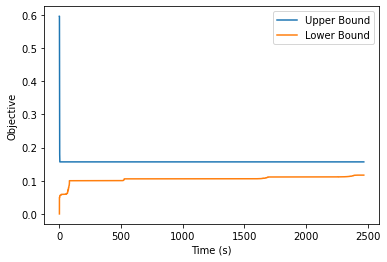

In [158]:
# plot the data
plt.figure()
plt.plot(octree_sample.times[1:], octree_sample.upper_bounds[1:], label="Upper Bound")
plt.plot(octree_sample.times[1:], octree_sample.lower_bounds[1:], label="Lower Bound")
plt.xlabel("Time (s)")
plt.ylabel("Objective")
plt.legend()
plt.show()

In [153]:
# OCT tree depth 2 with warm start
octree_sample_ws = optimalDecisionTreeClassifier(max_depth=2, min_samples_split=nmin, alpha=0.05, warmstart=True,
                                                timelimit=timelimit, output=False)
tick = time.time()
octree_sample_ws.fit(x_train, y_train)
tock = time.time()
train_time = tock - tick
train_acc = accuracy_score(y_train, octree_sample_ws.predict(x_train))
val_acc = accuracy_score(y_val, octree_sample_ws.predict(x_val))
test_acc = accuracy_score(y_test, octree_sample_ws.predict(x_test))
row = {'instance':"breast-cancer", 'depth':2, 'alpha':0.05, 'seed':42, 'train_acc':train_acc, 'val_acc':val_acc,
        'test_acc':test_acc, 'train_time':train_time, 'gap':octree_sample_ws.optgap}
print(row)

{'instance': 'breast-cancer', 'depth': 2, 'alpha': 0.05, 'seed': 42, 'train_acc': 0.9330985915492958, 'val_acc': 0.8732394366197183, 'test_acc': 0.9370629370629371, 'train_time': 3601.0256502628326, 'gap': 0.043010752688171394}


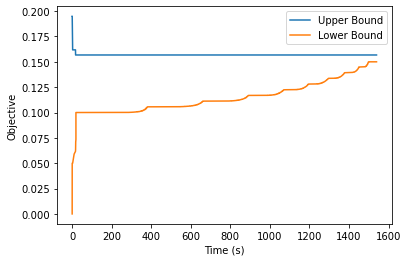

In [154]:
# plot the data
plt.figure()
plt.plot(octree_sample_ws.times, octree_sample_ws.upper_bounds, label="Upper Bound")
plt.plot(octree_sample_ws.times, octree_sample_ws.lower_bounds, label="Lower Bound")
plt.xlabel("Time (s)")
plt.ylabel("Objective")
plt.legend()
plt.show()

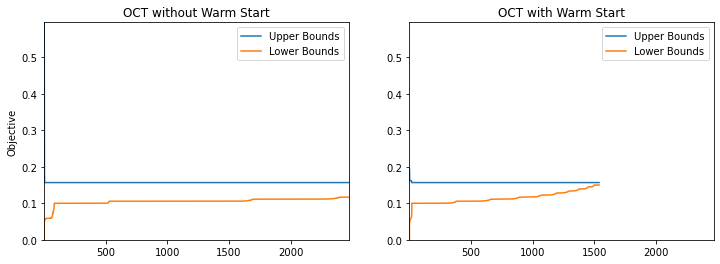

In [168]:
# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Plot the data on the first subplot
ax1.plot(octree_sample.times[1:], octree_sample.upper_bounds[1:], label='Upper Bounds')
ax1.plot(octree_sample.times[1:], octree_sample.lower_bounds[1:], label='Lower Bounds')
ax1.set_title('OCT without Warm Start')

# Plot the data on the second subplot
ax2.plot(octree_sample_ws.times, octree_sample_ws.upper_bounds, label='Upper Bounds')
ax2.plot(octree_sample_ws.times, octree_sample_ws.lower_bounds, label='Lower Bounds')
ax2.set_title('OCT with Warm Start')

# Set the same y-axis range for both subplots
ax1.set_ylim(np.min(octree_sample.lower_bounds[1:]), np.max(octree_sample.upper_bounds[1:]))
ax2.set_ylim(np.min(octree_sample.lower_bounds[1:]), np.max(octree_sample.upper_bounds[1:]))

# Set the same x-axis range for both subplots
ax1.set_xlim(np.min(octree_sample.times[1:]), np.max(octree_sample.times[1:]))
ax2.set_xlim(np.min(octree_sample.times[1:]), np.max(octree_sample.times[1:]))

ax2.tick_params(left=True, labelleft=True)
ax1.set_ylabel("Objective")
# Add legends
ax1.legend()
ax2.legend()

# Show the plot
plt.show()

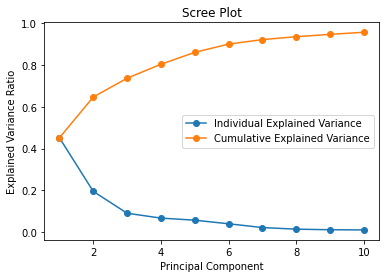

In [183]:
# Preprocess the data (scale and normalize)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

# Apply PCA to the training data
pca = PCA(n_components=0.95)
x_train_pca = pca.fit_transform(x_train)

# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Create the scree plot
fig, ax = plt.subplots()
ax.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'o-', label='Individual Explained Variance')
ax.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, 'o-', label='Cumulative Explained Variance')

# Format the scree plot
ax.set_title('Scree Plot')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance Ratio')
ax.legend()

# Show the scree plot
plt.show()